In [1]:
import pandas as pd
import os
import cv2
from collections import defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input

warnings.filterwarnings('ignore')


In [2]:
meta = pd.read_csv('dataset/archive/metadata.csv')
print(len(meta))
meta.head()

95634


,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [3]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['count'] = df.count().values
    summary_df['unique'] = df.nunique().values
    summary_df['missing#'] = df.isna().sum()
    summary_df['missing%'] = df.isna().sum() / len(df)
    return summary_df
summary(meta).style.background_gradient('Purples')

,dtypes,count,unique,missing#,missing%
videoname,object,95634,95634,0,0.000000
original_width,int64,95634,31,0,0.000000
original_height,int64,95634,34,0,0.000000
label,object,95634,2,0,0.000000
original,object,79341,16955,16293,0.170368


In [4]:
real_df = meta[meta['label'] == 'REAL'].sample(16000, random_state=42)
fake_df = meta[meta['label'] == 'FAKE'].sample(16000, random_state=42)
sample_meta = pd.concat([real_df, fake_df])

In [5]:
Train_set, Test_set = train_test_split(sample_meta, test_size=0.2, random_state=42, stratify=sample_meta['label'])
Train_set, Val_set = train_test_split(Train_set, test_size=0.3, random_state=42, stratify=Train_set['label'])

In [6]:
def retrieve_dataset(set_name):
    images, labels = [], []
    for (img, label) in zip(set_name['videoname'], set_name['label']):
        img_path = 'dataset/archive/faces_224/' + img[:-4] + '.jpg'
        img = cv2.imread(img_path)
        if img is None:
            continue
        images.append(img)
        labels.append(1 if label == 'FAKE' else 0)
    return np.array(images), np.array(labels)

X_train, y_train = retrieve_dataset(Train_set)
X_val, y_val = retrieve_dataset(Val_set)
X_test, y_test = retrieve_dataset(Test_set)

In [7]:
len(X_train)


17920

In [8]:
# --------------------------------------
# ✅ Region-Based CNN Feature Extraction (Original Logic w/ Fine-Tuned Model)
# --------------------------------------


# ✅ Load fine-tuned EfficientNetB4 model
fine_tuned_model = tf.keras.models.load_model("fine_tuned_efficientnet.h5")
region_feature_model = Model(inputs=fine_tuned_model.input, outputs=fine_tuned_model.layers[-2].output)

# ✅ Facial regions to extract
REGIONS = ['left_eye', 'right_eye', 'nose_bridge', 'top_lip', 'bottom_lip']

# -------------------------------
# Helper: Crop & Resize Region
# -------------------------------
def crop_and_resize_region(image, region_points):
    if not region_points:
        return None
    xs, ys = zip(*region_points)
    x_min, x_max = max(min(xs)-5, 0), min(max(xs)+5, image.shape[1])
    y_min, y_max = max(min(ys)-5, 0), min(max(ys)+5, image.shape[0])
    cropped = image[y_min:y_max, x_min:x_max]
    if cropped.size == 0:
        return None
    return cv2.resize(cropped, (224, 224))

# -------------------------------
# Helper: Extract region-level features
# -------------------------------
def extract_local_features(image):
    landmarks_list = face_recognition.face_landmarks(image)
    if not landmarks_list:
        return None
    landmarks = landmarks_list[0]
    all_feats = []
    for region in REGIONS:
        if region not in landmarks:
            return None
        region_img = crop_and_resize_region(image, landmarks[region])
        if region_img is None:
            return None
        region_input = preprocess_input(region_img.astype(np.float32))
        region_input = np.expand_dims(region_input, axis=0)
        feat = region_feature_model.predict(region_input, verbose=0).flatten()
        all_feats.append(feat)
    return np.concatenate(all_feats)

# -------------------------------
# Debug: Visualize landmark regions
# -------------------------------
def visualize_landmark_regions(image):
    landmarks_list = face_recognition.face_landmarks(image)
    if not landmarks_list:
        print("No landmarks detected.")
        return
    landmarks = landmarks_list[0]
    fig, axs = plt.subplots(1, len(REGIONS), figsize=(15, 3))
    for i, region in enumerate(REGIONS):
        if region not in landmarks:
            axs[i].set_title(f"{region}\nNot Found")
            axs[i].axis('off')
            continue
        region_img = crop_and_resize_region(image, landmarks[region])
        if region_img is not None:
            axs[i].imshow(region_img)
            axs[i].set_title(region)
            axs[i].axis('off')
    plt.tight_layout()
    plt.show()



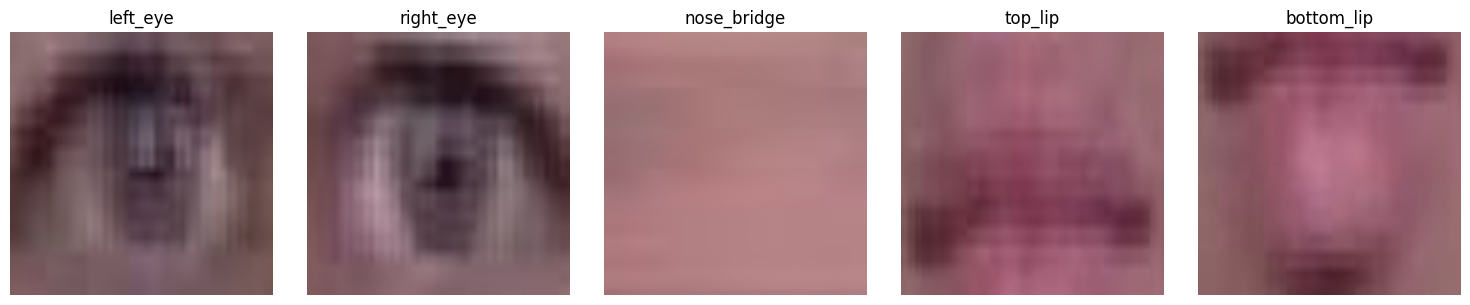

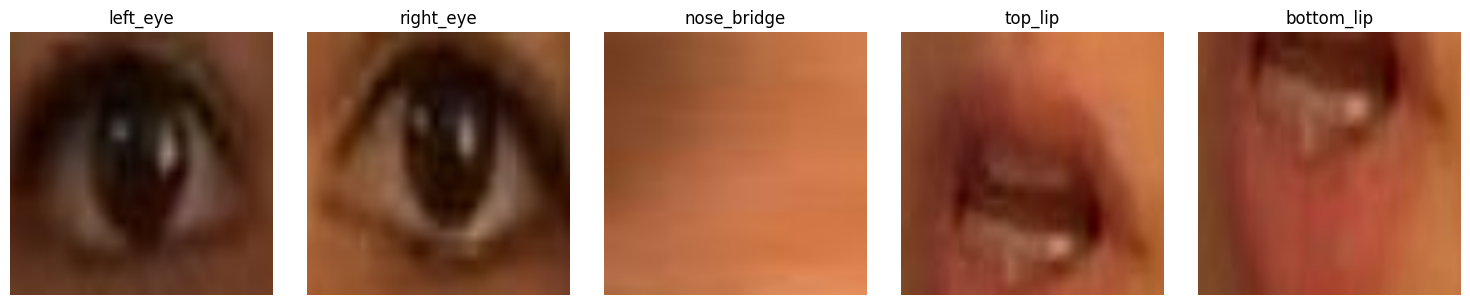

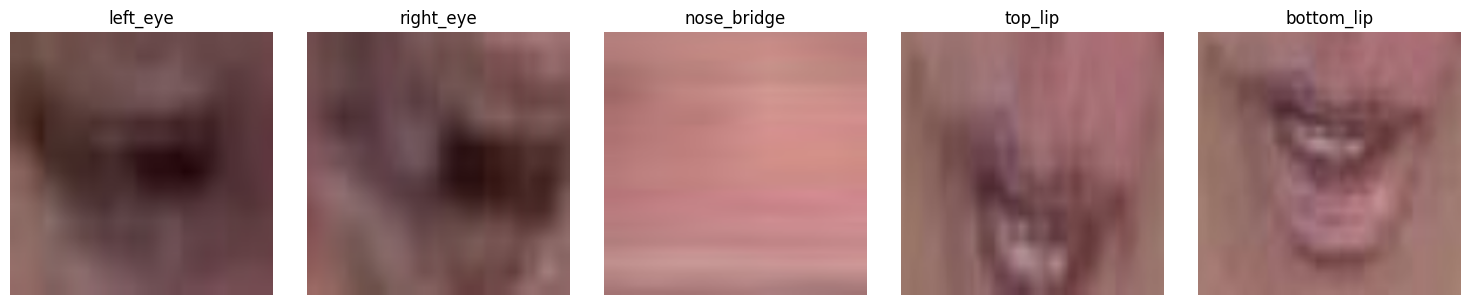

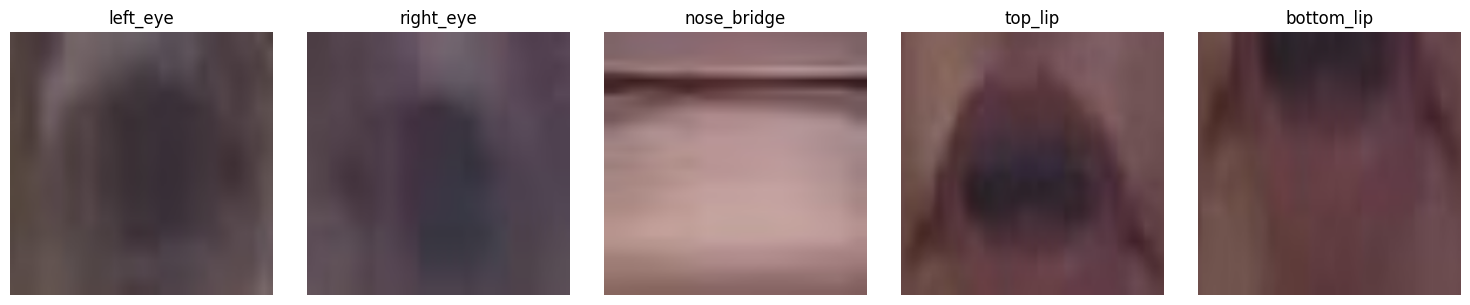

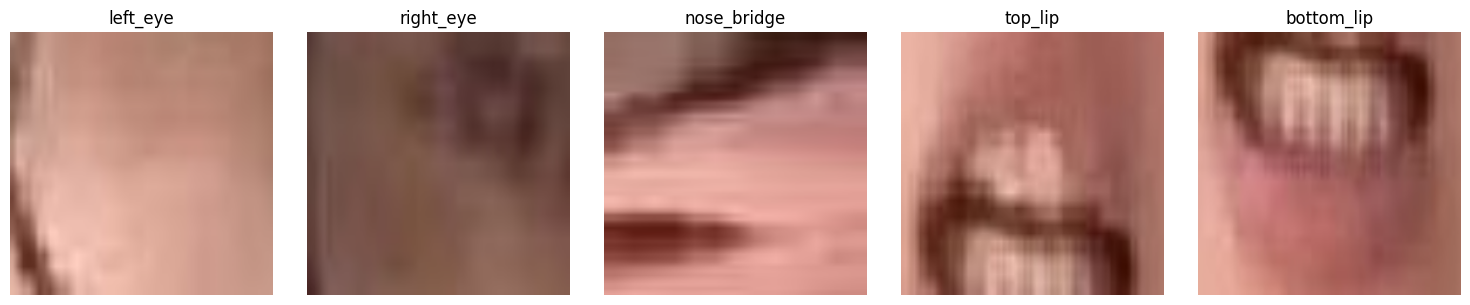

Saved region-based features for PGM input
Shape: (421, 8960)


In [9]:

# -------------------------------
# Randomly sample and extract
# -------------------------------
X_train_local, y_train_local = [], []
np.random.seed(42)
sample_indices = np.random.choice(len(X_train), size=500, replace=False)
X_train_sample = [X_train[i] for i in sample_indices]
y_train_sample = [y_train[i] for i in sample_indices]

for i, (img, label) in enumerate(zip(X_train_sample, y_train_sample)):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    local_feat = extract_local_features(img_rgb)
    if local_feat is not None:
        X_train_local.append(local_feat)
        y_train_local.append(label)
        #print(f"[Preview] Sample {i}, Label: {label}")
        if len(X_train_local) <= 5:
            visualize_landmark_regions(img_rgb)

X_train_local = np.array(X_train_local)
y_train_local = np.array(y_train_local)

np.save("X_train_local_feats.npy", X_train_local)
np.save("y_train_local_labels.npy", y_train_local)

print("Saved region-based features for PGM input")
print("Shape:", X_train_local.shape)

In [10]:
len(X_train)

17920

In [11]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

# Load region-based CNN features
X = np.load("X_train_local_feats.npy")  # shape: (404, 8960)
y = np.load("y_train_local_labels.npy")

# Train/test split (e.g., 80/20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_val)
y_proba = clf.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_pred))
print("AUC:", roc_auc_score(y_val, y_proba))

              precision    recall  f1-score   support

           0       0.54      0.60      0.57        42
           1       0.56      0.51      0.54        43

    accuracy                           0.55        85
   macro avg       0.55      0.55      0.55        85
weighted avg       0.55      0.55      0.55        85

AUC: 0.6068660022148394


In [12]:
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer
from pomegranate.distributions import Categorical, ConditionalCategorical
from pomegranate.bayesian_network import BayesianNetwork

# --- Load your saved region-based features and labels ---
X_train_local = np.load("X_train_local_feats.npy")   # shape (404, 8960)
y_train_local = np.load("y_train_local_labels.npy")  # shape (404,)

# --- Step 1: Extract 1 PCA component per region ---
n_regions = 5
region_dim = X_train_local.shape[1] // n_regions

region_feats = []
for i in range(n_regions):
    region_i = X_train_local[:, i * region_dim:(i + 1) * region_dim]
    pca = PCA(n_components=1)
    pca_feat = pca.fit_transform(region_i).flatten()  # shape (404,)
    region_feats.append(pca_feat)

region_feats = np.stack(region_feats, axis=1)  # shape: (404, 5)

# --- Step 2: Discretize with KBins ---
disc = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
region_disc = disc.fit_transform(region_feats).astype(int)  # shape: (404, 5)

# --- Step 3: Combine with labels for BN ---
data = np.hstack((region_disc, y_train_local.reshape(-1, 1)))  # shape: (404, 6)
print("Unique input rows for BN:", np.unique(data, axis=0).shape)

# --- Step 4: Build Bayesian Network ---
X_all = torch.tensor(data, dtype=torch.int64)

# Unpack features and label
X_cond = X_all[:, [0,1,2,3,4,5]].unsqueeze(-1)  # shape: (404, 6, 1)
n_categories = torch.max(X_cond.squeeze(-1), dim=0)[0] + 1
target_dist = ConditionalCategorical(n_categories=n_categories.tolist())
target_dist.fit(X_cond)

# Build BN
model = BayesianNetwork()
feature_dists = []

for i in range(5):
    dist = Categorical()
    dist.fit(X_all[:, i].unsqueeze(1))
    feature_dists.append(dist)
    model.add_distribution(dist)

model.add_distribution(target_dist)

# Add edges (features → target)
for dist in feature_dists:
    model.add_edge(dist, target_dist)

# --- Step 5: Loop over all samples for prediction ---
preds = []

for i in range(len(X_all)):
    x = X_all[i].unsqueeze(0)  # shape: (1, 6)
    m = torch.ones_like(x, dtype=torch.bool)
    m[0, -1] = False  # mask the target
    masked = torch.masked.masked_tensor(x, m)

    beliefs = model.predict_proba(masked)
    p = beliefs[-1].squeeze().detach().numpy()
    preds.append(p)

preds = np.array(preds)  # shape: (404, 2)

# --- Step 6: Print meaningful predictions ---
from scipy.stats import entropy

print(f"{'Index':<6} {'P(real)':<10} {'P(fake)':<10} {'Pred':<6} {'True':<6} {'Confidence':<12} {'Entropy':<10}")
print("-" * 70)

for i in range(10):  # first 10 samples
    p_real, p_fake = preds[i]
    pred_label = int(p_fake > p_real)
    true_label = int(X_all[i, -1].item())
    conf = max(p_real, p_fake)
    ent = entropy([p_real, p_fake])
    
    print(f"{i:<6} {p_real:<10.4f} {p_fake:<10.4f} {pred_label:<6} {true_label:<6} {conf:<12.4f} {ent:<10.4f}")


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Unique input rows for BN: (182, 6)
Index  P(real)    P(fake)    Pred   True   Confidence   Entropy   
----------------------------------------------------------------------
0      1.0000     0.0000     0      0      1.0000       0.0000    
1      0.6190     0.3810     0      0      0.6190       0.6645    
2      0.6667     0.3333     0      0      0.6667       0.6365    
3      0.6000     0.4000     0      0      0.6000       0.6730    
4      0.5000     0.5000     0      0      0.5000       0.6931    
5      0.3333     0.6667     1      0      0.6667       0.6365    
6      0.0000     1.0000     1      1      1.0000       0.0000    
7      0.6000     0.4000     0      0      0.6000       0.6730    
8      0.5000     0.5000     0      1      0.5000       0.6931    
9      0.6190     0.3810     0      1      0.6190       0.6645    


In [13]:

from scipy.stats import entropy

# Extract ground truth labels
true_labels = X_all[:, -1].numpy()
pred_labels = preds.argmax(axis=1)
confidences = preds.max(axis=1)
entropies = np.array([entropy(p) for p in preds])

# Correct / incorrect masks
correct = (pred_labels == true_labels)
incorrect = ~correct

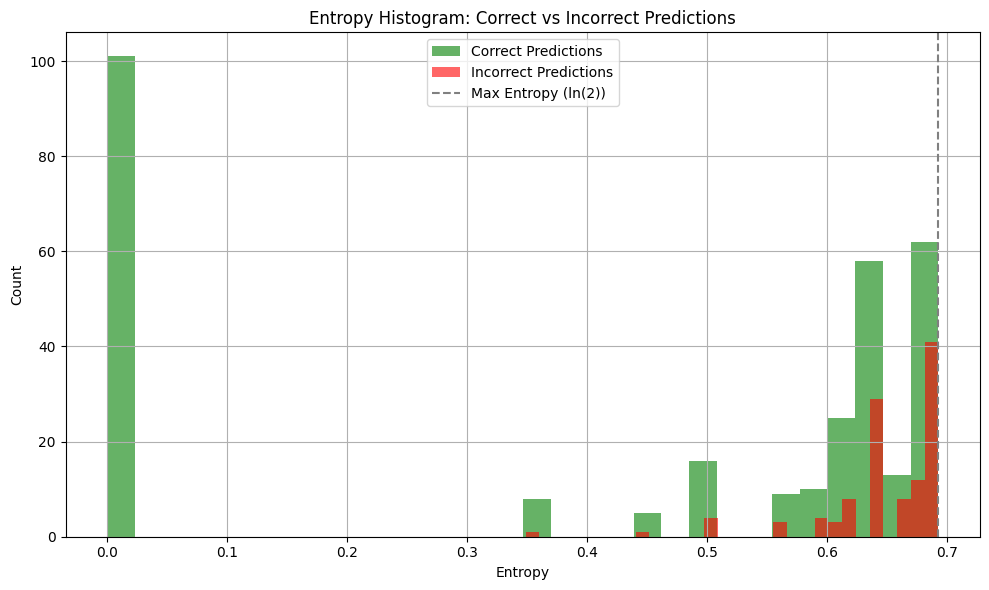

In [14]:
import matplotlib.pyplot as plt
# Plot: Entropy Histograms 
plt.figure(figsize=(10,6))
plt.hist(entropies[correct], bins=30, alpha=0.6, label="Correct Predictions", color="green")
plt.hist(entropies[incorrect], bins=30, alpha=0.6, label="Incorrect Predictions", color="red")
plt.axvline(x=np.log(2), color='gray', linestyle='--', label="Max Entropy (ln(2))")
plt.title("Entropy Histogram: Correct vs Incorrect Predictions")
plt.xlabel("Entropy")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Report: Average Stats 
for cls in [0, 1]:
    cls_mask = (true_labels == cls)
    avg_conf = confidences[cls_mask].mean()
    avg_ent = entropies[cls_mask].mean()
    print(f"Class {cls} (Ground Truth): Avg Confidence = {avg_conf:.4f}, Avg Entropy = {avg_ent:.4f}")


Class 0 (Ground Truth): Avg Confidence = 0.7144, Avg Entropy = 0.5043
Class 1 (Ground Truth): Avg Confidence = 0.7439, Avg Entropy = 0.4525


In [16]:
#Decision Thresholding
# Define thresholds
CONF_THRESH = 0.6
ENTROPY_THRESH = 0.65

# Flagged uncertain predictions
uncertain_mask = (confidences < CONF_THRESH) | (entropies > ENTROPY_THRESH)
flagged_indices = np.where(uncertain_mask)[0]

print(f"\nNumber of flagged uncertain predictions: {len(flagged_indices)}")
print(f"Percentage of flagged samples: {100 * len(flagged_indices) / len(preds):.2f}%")

# Among flagged, how many were incorrect?
flagged_incorrect = np.sum(incorrect[flagged_indices])
print(f"Incorrect among flagged: {flagged_incorrect} / {len(flagged_indices)} = {100 * flagged_incorrect / len(flagged_indices):.2f}%")

#how many confident-but-wrong predictions?
confident_wrong = np.sum((confidences > CONF_THRESH) & (entropies < ENTROPY_THRESH) & incorrect)
print(f"\nConfident but wrong predictions: {confident_wrong}")


Number of flagged uncertain predictions: 136
Percentage of flagged samples: 32.30%
Incorrect among flagged: 61 / 136 = 44.85%

Confident but wrong predictions: 53


In [1]:
# --------------------------------------
# ✅ Region-Based CNN Feature Extraction using Fine-Tuned Model (with Sampling)
# --------------------------------------
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input

# ✅ Load fine-tuned model (saved after Phase 1)
fine_tuned_model = tf.keras.models.load_model("fine_tuned_efficientnet.h5")
region_feature_model = Model(inputs=fine_tuned_model.input, outputs=fine_tuned_model.layers[-2].output)

# ✅ Facial regions to extract
REGIONS = ['left_eye', 'right_eye', 'nose_bridge', 'top_lip', 'bottom_lip']

# -------------------------------
# Helper: Crop & Resize Region
# -------------------------------
def crop_and_resize_region(image, region_points):
    if not region_points:
        return None
    xs, ys = zip(*region_points)
    x_min, x_max = max(min(xs)-5, 0), min(max(xs)+5, image.shape[1])
    y_min, y_max = max(min(ys)-5, 0), min(max(ys)+5, image.shape[0])
    cropped = image[y_min:y_max, x_min:x_max]
    if cropped.size == 0:
        return None

In [2]:
# -------------------------------
# Helper: Extract region-level features
# -------------------------------
def extract_local_features(image):
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)
    landmarks_list = face_recognition.face_landmarks(image)
    if not landmarks_list:
        return None
    landmarks = landmarks_list[0]
    all_feats = []
    for region in REGIONS:
        if region not in landmarks:
            return None
        region_img = crop_and_resize_region(image, landmarks[region])
        if region_img is None:
            return None
        region_input = preprocess_input(region_img.astype(np.float32))
        region_input = np.expand_dims(region_input, axis=0)
        feat = region_feature_model.predict(region_input, verbose=0).flatten()
        all_feats.append(feat)
    return np.concatenate(all_feats)

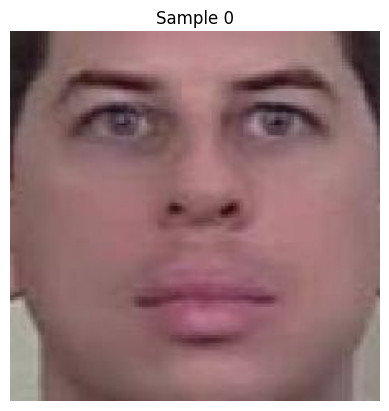

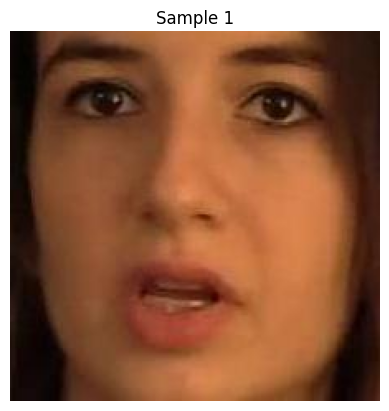

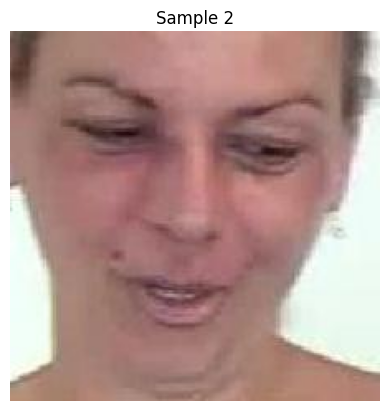

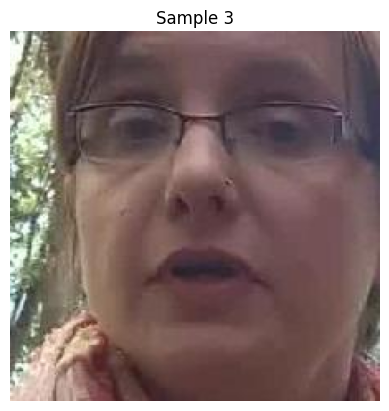

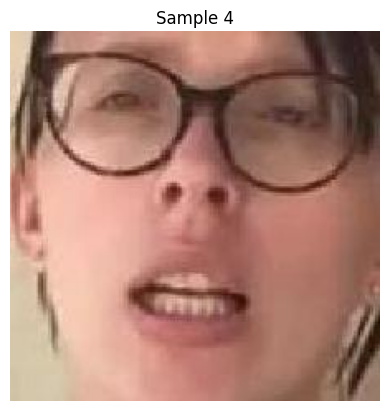

In [11]:
for i in range(5):
    img = X_train_sample[i]
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.uint8)
    plt.imshow(img_rgb)
    plt.title(f"Sample {i}")
    plt.axis("off")
    plt.show()


In [13]:
# ✅ Randomly sample and extract
# -------------------------------
np.random.seed(42)
sample_indices = np.random.choice(len(X_train), size=500, replace=False)
X_train_sample = [X_train[i] for i in sample_indices]
y_train_sample = [y_train[i] for i in sample_indices]

X_train_local, y_train_local = [], []



In [ ]:
for i, (img, label) in enumerate(zip(X_train_sample, y_train_sample)):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.uint8)
    local_feat = extract_local_features(img_rgb)
    if local_feat is not None:
        X_train_local.append(local_feat)
        y_train_local.append(label)
        print(f"[✅ Preview] Sample {i}, Label: {label}, Feature shape: {local_feat.shape}")
    else:
        print(f"[⛔ Skipped] Sample {i}, no features.")
for i, (img, label) in enumerate(zip(X_train_sample, y_train_sample)): img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
local_feat = extract_local_features(img_rgb)
if local_feat is not None:
X_train_local.append(local_feat) y_train_local.append(label)
if len(X_train_local) <= 5:

In [12]:
img_rgb = cv2.cvtColor(X_train_sample[0], cv2.COLOR_BGR2RGB).astype(np.uint8)
landmarks = face_recognition.face_landmarks(img_rgb)
print("Landmarks found:", landmarks[0].keys() if landmarks else "None")


Landmarks found: dict_keys(['chin', 'left_eyebrow', 'right_eyebrow', 'nose_bridge', 'nose_tip', 'left_eye', 'right_eye', 'top_lip', 'bottom_lip'])


In [9]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

# Load region-based CNN features
X = np.load("X_train_local_feats.npy")  # shape: (404, 8960)
y = np.load("y_train_local_labels.npy")

# Train/test split (e.g., 80/20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_val)
y_proba = clf.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_pred))
print("AUC:", roc_auc_score(y_val, y_proba))

              precision    recall  f1-score   support

           0       0.54      0.60      0.57        42
           1       0.56      0.51      0.54        43

    accuracy                           0.55        85
   macro avg       0.55      0.55      0.55        85
weighted avg       0.55      0.55      0.55        85

AUC: 0.6068660022148394


In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# -------------------------------
# 1. Load region-based features
# -------------------------------
X = np.load("X_train_local_feats.npy")
y = np.load("y_train_local_labels.npy")

# -------------------------------
# 2. Train/Test split
# -------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# 3. PCA for dimensionality reduction
# -------------------------------
# Try different n_components: 100, 200, 300, etc.
pca = PCA(n_components=200, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

print("Original shape:", X_train.shape)
print("Reduced shape:", X_train_pca.shape)

# -------------------------------
# 4. Logistic Regression
# -------------------------------
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_val_pca)
y_proba = clf.predict_proba(X_val_pca)[:, 1]

# -------------------------------
# 5. Evaluation
# -------------------------------
print(classification_report(y_val, y_pred))
print("AUC:", roc_auc_score(y_val, y_proba))


Original shape: (336, 8960)
Reduced shape: (336, 200)
              precision    recall  f1-score   support

           0       0.53      0.57      0.55        42
           1       0.55      0.51      0.53        43

    accuracy                           0.54        85
   macro avg       0.54      0.54      0.54        85
weighted avg       0.54      0.54      0.54        85

AUC: 0.5930232558139535
